In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai import RIMUnet, PhysicalModel, RIM, RIMSharedUnet
from censai.utils import rim_residual_plot, update
from censai.data.lenses_tng import decode_train, decode_physical_model_info
import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

# Shared Unet

# Scale Dataset 512 k128

In [67]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_SDS.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,filters,filter_scaling,kernel_size,layers,block_conv_layers,strides,bottleneck_kernel_size,bottleneck_filters,resampling_kernel_size,gru_kernel_size,upsampling_interpolation,kernel_regularizer_amp,bias_regularizer_amp,activation,alpha,initializer,kappa_resize_filters,kappa_resize_method,kappa_resize_conv_layers,kappa_resize_strides,kappa_resize_kernel_size,kappa_resize_separate_grad_downsampling,batch_size,total_items,optimizer,seed,experiment_id,train_cost,val_cost,train_chi_squared,val_chi_squared,best_score
1,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,5,100,Adam,42,RIMSU512_k128_SDS_001_TI100_B5_210724195848,0.025559,0.038752,0.720245,3.735015,0.025560
0,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,100,Adam,42,RIMSU512_k128_SDS_000_TI100_B1_210724195848,0.001692,0.038476,0.336212,0.473320,0.001581
2,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,10,100,Adam,42,RIMSU512_k128_SDS_002_TI100_B10_210724195848,0.008426,0.052196,0.723703,0.144652,0.005711
5,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,10,500,Adam,42,RIMSU512_k128_SDS_005_TI500_B10_210724195901,0.010447,0.038988,0.592514,1.274803,0.009382
4,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,5,500,Adam,42,RIMSU512_k128_SDS_004_TI500_B5_210724195901,0.002829,0.043254,0.786680,0.621704,0.002766
6,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SDS_006_TI1000_B1_210724195901,0.007893,0.043945,1.011483,0.362284,0.006471
3,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,500,Adam,42,RIMSU512_k128_SDS_003_TI500_B1_210724195848,0.002281,0.040195,1.336384,3.795889,0.001447
7,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,5,1000,Adam,42,RIMSU512_k128_SDS_007_TI1000_B5_210724195901,0.002372,0.046019,1.083795,6.135693,0.002004


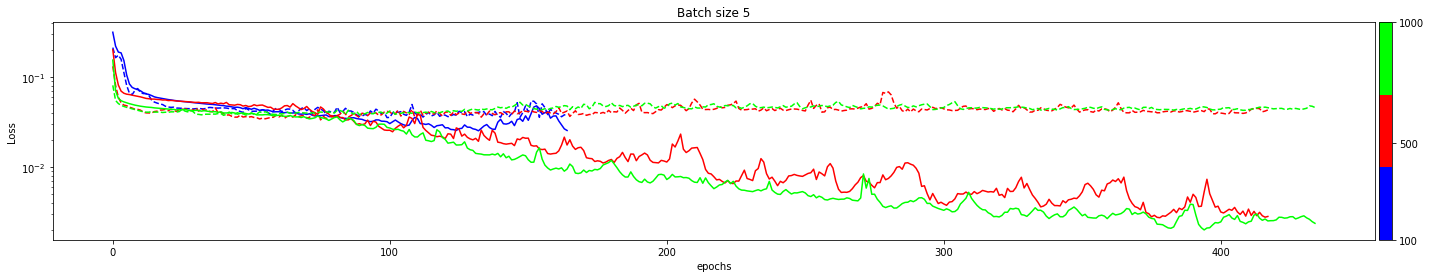

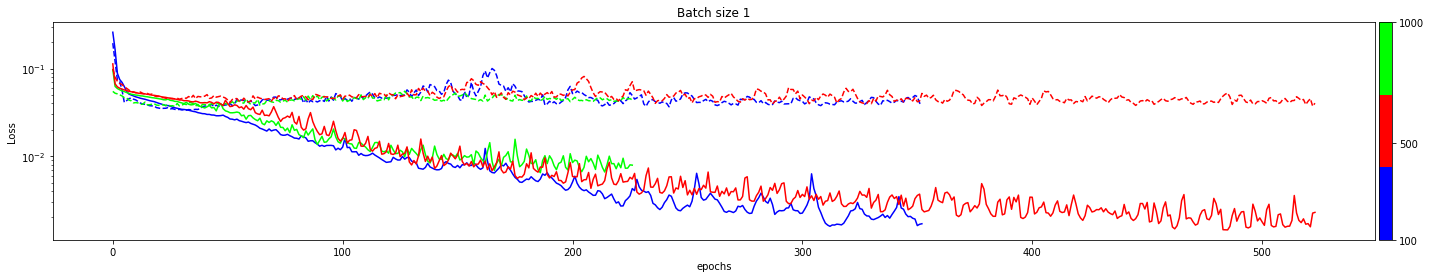

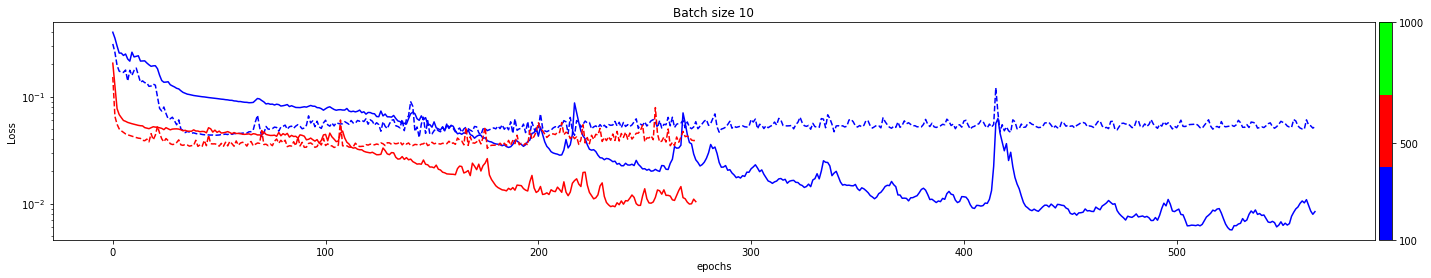

In [65]:
cmap = mpl.cm.get_cmap("brg", 3)
norm = mpl.colors.Normalize(vmin=hparams["total_items"].min(), vmax=hparams["total_items"].max())
for batch_size in hparams["batch_size"].unique():
    plt.figure(figsize=(24, 4))
    ax = plt.gca()
    for experiment_id, curves in histories.items():
        epochs = curves
        total_items = hparams[(hparams["experiment_id"] == experiment_id) & (hparams["batch_size"] == batch_size)]["total_items"]
        if total_items.size != 0:
            plt.plot([curves["train_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="-", color=cmap(norm(total_items)))
            plt.plot([curves["val_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="--", color=cmap(norm(total_items)))

    plt.title(f"Batch size {batch_size}")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.get_yaxis().set_ticks(hparams["total_items"].unique())

# Scale Filters 512 k128

In [68]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_SF.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,filters,filter_scaling,kernel_size,layers,block_conv_layers,strides,bottleneck_kernel_size,bottleneck_filters,resampling_kernel_size,gru_kernel_size,upsampling_interpolation,kernel_regularizer_amp,bias_regularizer_amp,activation,alpha,initializer,kappa_resize_filters,kappa_resize_method,kappa_resize_conv_layers,kappa_resize_strides,kappa_resize_kernel_size,kappa_resize_separate_grad_downsampling,batch_size,total_items,optimizer,seed,experiment_id,train_cost,val_cost,train_chi_squared,val_chi_squared,best_score
10,4,True,True,False,identity,0.1,0.001,32,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_010_F32_FS2_TI1000_210724203621,0.002761,0.036436,0.675994,2.034342,0.002239
8,4,True,True,False,identity,0.1,0.001,32,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_008_F32_FS1_TI1000_210724203213,0.004284,0.107336,1.393330,0.388692,0.003074
